#Recommendation Systems in Machine Learning

## Week 5 - MLPs, CNNs, and AEs

This week, we'll take a look at the basics of a neural network and how multilayer perceptrons, convolutional neural networks, and autoencoders are used in practice. 

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



The first thing we'll need to do is import a dataset. We'll be using the MovieLens dataset again. Before you run this block of code, please make sure that you've uploaded the 'ml-latest-small.zip' into the folder with this notebook. 

We begin by mounting our drive and loading the dataset as we did in week 1.

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
DRIVE_PREFIX = '/content/drive/MyDrive/Colab Notebooks/'

Mounted at /content/drive/


This block of code will open the zipfile and read the data in that zip file into a folder called "MovieLens Data".

In [3]:
import zipfile as zf
files = zf.ZipFile(DRIVE_PREFIX + "ml-latest-small.zip", 'r')
files.extractall("MovieLens-Data")
files.close()

We'll use the same formatting for our data, based on the movieId

In [4]:
movies = pd.read_csv("MovieLens-Data/ml-latest-small/movies.csv")
ratings = pd.read_csv("MovieLens-Data/ml-latest-small/ratings.csv")
data = ratings.merge(movies, on='movieId', how='left')
data.head(10)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
5,1,70,3.0,964982400,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
6,1,101,5.0,964980868,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance
7,1,110,4.0,964982176,Braveheart (1995),Action|Drama|War
8,1,151,5.0,964984041,Rob Roy (1995),Action|Drama|Romance|War
9,1,157,5.0,964984100,Canadian Bacon (1995),Comedy|War


Let's define our problem - we want to create a neural network that will estimate how a particular user (let's choose user 10 for simplicity) will rate a movie given the movie ID and the genres corresponding with that movie. 

Since the movie name itself is only really for reference, let's create a new dataframe just to store the mapping from movieId to the title before we do any processing.

In [5]:
idToMovie = data[['movieId', 'title']]
idToMovie = idToMovie.drop_duplicates()
idToMovie = idToMovie.sort_values(by=['movieId'])
idToMovie = idToMovie.reset_index()
idToMovie = idToMovie.drop('index', axis = 1)
idToMovie.head(10)

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
5,6,Heat (1995)
6,7,Sabrina (1995)
7,8,Tom and Huck (1995)
8,9,Sudden Death (1995)
9,10,GoldenEye (1995)


We can drop the title column from the original data now

In [6]:
data = data.drop('title', axis=1)

Our first step will be to convert the "genres" column into features usable by our neural network. In this case, that means we'll binarize the output by one-hot encoding it. 

In [7]:
all_genres = ["Action", "Adventure", "Animation", "Children's", 
              "Comedy", "Crime", "Documentary", "Drama", 
              "Fantasy", "Film-Noir", "Horror", "Musical", 
              "Mystery", "Romance", "Sci-Fi", "Thriller", 
              "War", "Western"]

for genre in all_genres:
  data[genre] = data['genres'].str.contains(genre).astype(int)

data = data.drop('genres', axis=1)
data = data.drop('timestamp', axis=1)
data.head(10)

,userId,movieId,rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1,3,4.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,6,4.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,1,47,5.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,1,50,5.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
5,1,70,3.0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0
6,1,101,5.0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0
7,1,110,4.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
8,1,151,5.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
9,1,157,5.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


Let's choose the data corresponding to user 10. 

In [8]:
data = data[data['userId'] == 10]
data = data.drop('userId', axis=1)
data.head(10)

,movieId,rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1119,296,1.0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0
1120,356,3.5,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0
1121,588,4.0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1122,597,3.5,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1123,912,4.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1124,1028,0.5,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
1125,1088,3.0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
1126,1247,3.0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
1127,1307,3.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1128,1784,3.5,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0


Recall that we want to know how this user will rate a particular movie (based on the genre features). Let's separate the dataset into input (x) and output (y) and also convert them into NumPy arrays.

In [9]:
x = data[all_genres].values
#The following normalization is meant to allow for us to
#use the sigmoid function within our final layers for our neural 
#networks. 
y = (data[['rating']].values)/5

Let's now split the data into testing and training datasets. We'll split our data 80-20 (80% train, 20% test). This will be used in all of our following neural networks. 

In [10]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y)

### Vanilla Neural Network

Now that we have our data for our neural network, we're going to start building a simple two layer neural network. In most literature, the input layer for a neural network is not referred to as a "layer" in the description of the neural network. Therefore, when we say "two layer neural network", we are referring to a neural network that will have one hidden layer and one output layer. We will write the neural network one function at a time, and then combine the functions into a VNN class. 

The image below resembles the network we will create - in particular, our network will have **18** neurons in the input layer, **5** in the hidden layer, and **1** in the output layer. 

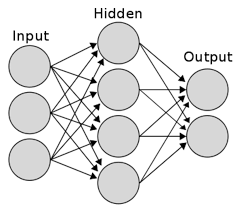

First, lets write our initialization function for the network. This initialization function will take in the input data x and the corresponding desired output y and initialize the starting weights for each layer to random values, along with a zero-filled output array of the same shape as our desired output y. This function will also set a default learning rate for our network (in practice this is set via an input parameter)

#### **Todo:**

Please write the code necessary to create vectors w1, w2, and b1. If you're confused, please read the intro to this section (above) again and review this week's lecture.



In [11]:
def __init__(self, x, y):
  self.input = x
  ####### FILL IN THE BLANK #######
  self.w1 = np.random.rand(18, 5)
  self.w2 = np.random.rand(5, 1)
  self.b1 = np.random.rand(1, 5)
  #################################
  self.b2 = np.random.rand(1, 1)        
  self.y = y
  self.output = np.zeros(self.y.shape)
  self.lr = 1

The next function we will define is the forward pass function. Recall from lecture that the forward pass of data through a neural network simply refers to multiplying the weights and adding the biases for each layer of the neural network. At each layer, we also have to pass the result from that layer through an activation function. In practice, activation functions are normally applied on a layer by layer basis instead of a neuron by neuron basis in order to make the underlying operations simpler. 

In our network, we will use the sigmoid activation function, which can be seen below:

<img src = "https://qph.fs.quoracdn.net/main-qimg-6b67bea3311c3429bfb34b6b1737fe0c">

We will also define a function for the derivative of the sigmoid function here - we will need it later in the backpropagation step for our neural network.



In [20]:
def sigmoid(self, x):
  ####### FILL IN THE BLANK #######
  return 1 / (1 + np.exp(-x))
  #################################

def sigmoidprime(self, z):
  # z in this case refers to sigmoid(x)
  return z * (1 - z)


The following graphic provides a flow map interpretation of the **forward propagation** (also known as **feedforward**) process.

<img src = "https://miro.medium.com/max/1120/1*CEtt0h8Rss_qPu7CyqMTdQ.png">

In [13]:
def forwardprop(self, x):
  self.hidden = self.sigmoid(np.dot(x, self.w1) + self.b1)
  return self.sigmoid(np.dot(self.hidden, self.w2) + self.b2)

The next thing we will need to define is a measure of how "wrong" our predictions are from the correct outputs. This is known as **loss function** and was introduced in lecture. 

**Todo:**

Implement the **mean squared error** loss function below. Some segments of the code are already filled in for you - just fill in the blanks. For reference, you can find the definition of the mean squared error loss function below.

<img src = "https://cdn-media-1.freecodecamp.org/images/hmZydSW9YegiMVPWq2JBpOpai3CejzQpGkNG" width=200>

In our code, we label the predicted value (the symbol of y with a tilde above it) as `ypred`, and the expected output as `y`. 

For the neural network, its important that the code you write follows the formula above **exactly**. If it doesn't, the neural network likely will not converge. 

In [22]:
def loss(self, ypred, y):
  n = len(y)
  squaredsum = 0.0
  for i in range(n):
    yi = y[i]
    ypredi = ypred[i]
    ####### FILL IN THE BLANK #######
    squaredsum += (yi - ypredi) ** 2
    #################################
  return squaredsum / n

While we're on the subject of loss, let's create a function that will give us a measure of the accuracy of a particular output for our network.

In [15]:
def accuracy(self, ypred, y):
  n = len(y)
  total = 0
  for i in range(n):
    yi = y[i]
    ypredi = ypred[i]
    if abs(yi - ypredi) < .05:
      total += 1
  return 100 * total/n

Next, we'll code up the backpropagation process. For our example, we'll hardcode it for two layers (in practice, the variables referring to each layer are stored in an array and the backpropagation function iterates through that array). 

For a review of backpropagation, please refer back to the lecture and slides for this week (the code below will be commented but will not represent an in-depth derivation of the algorithm)

**There will not be an exercise for this section** - just follow through as best as you can! If you have any questions, feel free to email an instructor or post it on Piazza.

In [16]:
def backwardprop(self):
  # For the following
  # yp refers to the output of the output layer
  # z refers to the output of the hidden layer
  # L refers to the output of the loss computation
  # From our definitions of the loss function L and
  # the activation functions for the layers, we know that

  # dL/dyp = 2 * (y - yp) / n
  dLdyp = -2 * (self.y - self.output) / len(self.y)

  # dL/dw2 = dL/dyp * dyp/dw2 = dL/dyp * sigmoidprime(yp) . z
  dLdw2 = np.dot(self.hidden.T, dLdyp * self.sigmoidprime(self.output)) 

  # dL/db2 = dL/dyp * dyp/db2 = dL/dyp * sigmoidprime(yp) 
  dLdb2 = np.dot(np.ones((1, len(self.y))), dLdyp * self.sigmoidprime(self.output))

  # dL/dw1 = dL/dyp * dyp/dz * dz/dw1 = dL/dyp * sigmoidprime(yp) . w2 * sigmoidprime(z) . x
  dLdw1 = np.dot(self.input.T,  (np.dot(dLdyp * self.sigmoidprime(self.output), self.w2.T) * self.sigmoidprime(self.hidden)))

  # dL/db1 = dL/dyp * dy/dz * dz/db1 = dL/dyp * sigmoidprime(yp) . w2 * sigmoidprime(z)
  dLdb1 = np.dot(np.ones((1, len(self.y))), np.dot(dLdyp * self.sigmoidprime(self.output), self.w2.T) * self.sigmoidprime(self.hidden))

  # the final step after calculating the above derivatives is to update the
  # weights and biases accordingly
  self.w2 -= self.lr * dLdw2
  self.b2 -= self.lr * dLdb2
  self.w1 -= self.lr * dLdw1
  self.b1 -= self.lr * dLdb1


And now, finally, we write our training loop. This function will take as input a number of epochs. For every training epoch, we will run forward and backward propagation to train the network.

**Todo:**

Fill in the code below that **computes the loss for the epoch and adds that value to the epoch_losses list**.

In [18]:
def train(self, epochs):
  epoch_losses = []
  accuracies = []
  for epoch in range(epochs):
    self.output = self.forwardprop(self.input)
    ####### FILL IN THE BLANK #######
    epoch_loss = self.loss(self.output, self.y)
    epoch_losses.append(epoch_loss)
    #################################
    acc = self.accuracy(self.output, self.y)
    accuracies.append(acc)
    self.backwardprop()
    
    if epoch % 100 == 0:
      print('Epoch %d: Loss %5f, Accuracy %2f' % (epoch, epoch_loss, acc))

  #plot loss and accuracy
  fig, ax = plt.subplots(2, 1)
  fig.tight_layout()
  ax[0].plot(epoch_losses)
  ax[0].set_title("Loss vs Epoch")
  ax[1].plot(accuracies)
  ax[1].set_title("Accuracy vs Epoch")
    

Epoch 0: Loss 0.112408, Accuracy 9.523810
Epoch 100: Loss 0.050076, Accuracy 20.000000
Epoch 200: Loss 0.049947, Accuracy 20.000000
Epoch 300: Loss 0.049812, Accuracy 20.000000
Epoch 400: Loss 0.049667, Accuracy 23.809524
Epoch 500: Loss 0.049504, Accuracy 23.809524
Epoch 600: Loss 0.049318, Accuracy 23.809524
Epoch 700: Loss 0.049101, Accuracy 23.809524
Epoch 800: Loss 0.048847, Accuracy 23.809524
Epoch 900: Loss 0.048545, Accuracy 20.000000


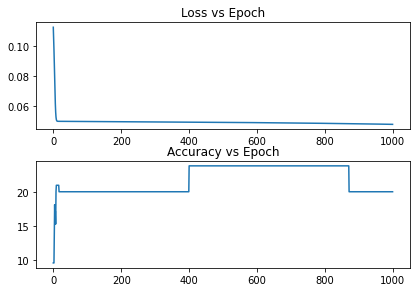

In [23]:
class VNN():
    pass

VNN.__init__ = __init__
VNN.sigmoid = sigmoid
VNN.sigmoidprime = sigmoidprime
VNN.forwardprop = forwardprop
VNN.loss = loss
VNN.accuracy = accuracy
VNN.backwardprop = backwardprop
VNN.train = train

myfirstnn = VNN(xTrain, yTrain)
myfirstnn.train(1000)

Alright so....it does **not** perform well (it's plateauing at around 20% accuracy on the training dataset). Maybe the testing dataset will somehow perform ok?

In [24]:
ytestpred = myfirstnn.forwardprop(xTest)
myfirstnn.accuracy(ytestpred, yTest)

22.857142857142858

Not really, its pretty similar. (You might get different numbers every time you run the network since the parameters are randomized to begin with. This is normal for most neural networks, but the result in this case should vary between 15% and 35% on average)

From this, we can tell several things:
1. It's possible that the data for this problem simply isn't suited to a neural network solution
2. The loss function and model parameters (number of neurons and layers) may not be optimal
3. It is likely that making a wider model (more neurons in the first two layers) will not help improve the results that much

This first section serves as the end of the part of the assignment you will have to fill. The rest of the assignment explores sample implementations of CNNs and Autoencoders to see if they will perform better on this problem.

Interesting side note: if you happened to actually look at the outputs of the neural network from above, you'll notice that its mostly just guessing values around 0.65 or so. We can take a look at the distribution of ratings in the dataset to see why that is.

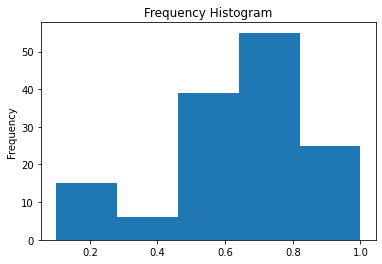

In [25]:
plt.hist(y, bins=5)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

As you can see, most of the values fall between 0.6 and 0.8 (which correspond to ratings of 3 and 4). Essentially, the neural network is learning that the most common ratings are 3 and 4 and then just guessing that for everything.

### Convolutional Neural Network

The following sections do not require you to write code, but we do encourage you to try to understand the code and how we are constructing the convolutional neural network for this problem. 

We will be using the PyTorch library to construct a two layer convolutional neural network for this problem.

In this cell, we define a BasicConv module using PyTorch, with two 1D convolutional layers and two fully connected layers. We also define our 'criterion', which is PyTorch's version of a loss function and the optimizer we will use for the neural network (stochastic gradient descent in this case). 

In [26]:
class BasicConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 2, 1)
        self.conv2 = nn.Conv1d(2, 3, 1)
        self.fc1 = nn.Linear(54, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x


basic_conv = BasicConv()
criterion = nn.MSELoss()
optimizer = optim.SGD(basic_conv.parameters(), lr=.1, momentum=0.9)

These are some utility functions for the actual training of the network itself. convert_input takes a numpy array and converts it into a PyTorch tensor with the appropriate dimensions. conv_accuracy is a duplicate of our earlier accuracy function, but since we used that accuracy function as part of a class we can't use it outside of one here. 



In [27]:
def convert_input(x):
  x = torch.from_numpy(x)
  x = x.unsqueeze(1)
  x = x.float()
  return x

def conv_accuracy(ypred, y):
  n = len(y)
  total = 0
  for i in range(n):
    yi = y[i]
    ypredi = ypred[i]
    if abs(yi - ypredi) < .05:
      total += 1
  return 100 * total/n

Here, we train our neural network for 1000 iterations. During the inner loop, we run through similar steps as in our manual neural network from earlier for each training example. Make sure to read through the code and ask any questions you may have on Piazza. 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: Loss 0.026027, Accuracy 20.952381
Epoch 100: Loss 0.037826, Accuracy 28.571429
Epoch 200: Loss 0.048788, Accuracy 42.857143
Epoch 300: Loss 0.046597, Accuracy 44.761905
Epoch 400: Loss 0.035826, Accuracy 40.000000
Epoch 500: Loss 0.033715, Accuracy 40.952381
Epoch 600: Loss 0.033881, Accuracy 40.952381
Epoch 700: Loss 0.035272, Accuracy 39.047619
Epoch 800: Loss 0.034553, Accuracy 40.000000
Epoch 900: Loss 0.033478, Accuracy 40.000000


Text(0.5, 1.0, 'Accuracy vs Epoch')

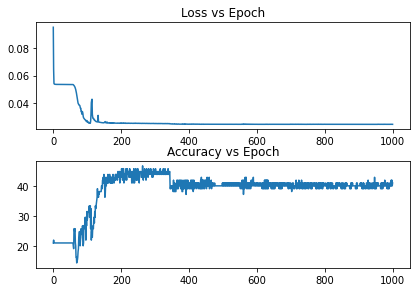

In [28]:
num_epochs = 1000
epoch_losses = []
accuracies = []
xTrainConvert = convert_input(xTrain)
yTrainConvert = convert_input(yTrain)

for epoch in range(num_epochs):  
    running_loss = 0.0

    for i in range(len(xTrainConvert)):
        x = xTrainConvert[i].unsqueeze(0)
        y = yTrainConvert[i].unsqueeze(0)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward prop
        outputs = basic_conv(x)
        # compute loss
        loss = criterion(outputs, y)
        # backward prop
        loss.backward()
        # gradient update
        optimizer.step()

        running_loss += loss.item()
        
    epoch_losses.append(running_loss/len(xTrain))
    preds = basic_conv(xTrainConvert).detach().numpy()
    acc = conv_accuracy(preds, yTrain)
    accuracies.append(acc)
    if epoch % 100 == 0:
      print('Epoch %d: Loss %5f, Accuracy %2f' % (epoch, loss, acc))

#plot loss and accuracy
fig, ax = plt.subplots(2, 1)
fig.tight_layout()
ax[0].plot(epoch_losses)
ax[0].set_title("Loss vs Epoch")
ax[1].plot(accuracies)
ax[1].set_title("Accuracy vs Epoch")

It seems to be performing better than the vanilla neural network from before. We can also check by looking at the test accuracy.

In [29]:
preds = basic_conv(convert_input(xTest)).detach().numpy()
conv_accuracy(preds, yTest)

22.857142857142858

So the improvement part is debatable (results may vary).However, it's well worth noting that even a convolutional neural network (albeit a shallow one) isn't able to fully learn the features of the dataset. Machine learning is not as simple as just throwing a neural network at the problem, as we can see in this case, due to limitations and biases within the data. 